In [1]:
# Cryptocurrency Price Prediction with LSTM
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from IPython.display import display

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning)

from utils import download_crypto_data, scale_data


In [2]:
# =============================================================================
# GLOBAL CONFIGURATION PARAMETERS
# =============================================================================

# Data Configuration
SYMBOL = "BTCUSDT"                    # Trading pair symbol
INTERVAL = "5m"                       # Time interval (1m, 5m, 15m, 1h, 4h, 1d)
DATA_FROM = "2021 01"                 # Start date for data download (YYYY MM)
DATA_TO = "2021 01"                   # End date for data download (YYYY MM)

# Model Configuration
LSTM_UNITS = 50                       # Number of LSTM units
DROPOUT_RATE = 0.2                    # Dropout rate for regularization
EPOCHS = 50                           # Number of training epochs
BATCH_SIZE = 32                       # Batch size for training
TEST_SIZE = 0.2                       # Proportion of data for testing (0.2 = 20%)

# Feature Engineering Configuration
LAG_PERIOD = 5                        # Single lag period for all columns
SEQUENCE_LENGTH = 10                  # Number of previous candles to use for prediction

# Prediction Configuration
PREDICTION_LENGTH = 1                 # Number of future steps to predict
SAMPLE_SIZE = 200                     # Number of samples for demonstration

# Visualization Configuration
MAX_POINTS = 2000                     # Maximum points to plot for performance
MAX_SAMPLES = 1000                    # Maximum samples for prediction plots

print("✅ Global configuration loaded successfully!")
print(f"📊 Data: {SYMBOL} {INTERVAL} from {DATA_FROM} to {DATA_TO}")
print(f"🧠 Model: {LSTM_UNITS} units, {EPOCHS} epochs, batch size {BATCH_SIZE}")
print(f"🔧 Features: {LAG_PERIOD} lag period, {SEQUENCE_LENGTH} candle sequence, no rolling windows")


✅ Global configuration loaded successfully!
📊 Data: BTCUSDT 5m from 2021 01 to 2021 01
🧠 Model: 50 units, 50 epochs, batch size 32
🔧 Features: 5 lag period, 10 candle sequence, no rolling windows


## Data Loading

This section contains functions to download and load cryptocurrency data from Binance.


In [3]:
def generate_date_range(from_date, to_date):
    """
    Generate years and months from date range.
    
    Args:
        from_date (str): Start date in "YYYY MM" format
        to_date (str): End date in "YYYY MM" format
    
    Returns:
        tuple: (years, months) - lists of years and months to download
    """
    from datetime import datetime
    
    start_year, start_month = from_date.split()
    end_year, end_month = to_date.split()
    
    start_year = int(start_year)
    start_month = int(start_month)
    end_year = int(end_year)
    end_month = int(end_month)
    
    years = []
    months = []
    
    current_year = start_year
    current_month = start_month
    
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        year_str = str(current_year)
        month_str = f"{current_month:02d}"
        
        if year_str not in years:
            years.append(year_str)
        if month_str not in months:
            months.append(month_str)
        
        # Move to next month
        if current_month == 12:
            current_year += 1
            current_month = 1
        else:
            current_month += 1
    
    return years, months


def load_data_by_date_range(symbol, interval, from_date, to_date):
    """
    Load data for a specific date range, combining into a single DataFrame.
    
    Args:
        symbol (str): Trading pair symbol
        interval (str): Time interval
        from_date (str): Start date in "YYYY MM" format
        to_date (str): End date in "YYYY MM" format
    
    Returns:
        pd.DataFrame: Combined DataFrame with all data in the date range
    """
    years, months = generate_date_range(from_date, to_date)
    print(f"Loading data from {from_date} to {to_date}")
    print(f"Years: {years}")
    print(f"Months: {months}")
    
    all_data = []
    
    for year in years:
        print(f"Loading data for year {year}...")
        year_data = load_multiple_months_data(symbol, interval, year, months)
        if year_data is not None:
            all_data.append(year_data)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df = combined_df.sort_values('Open time').reset_index(drop=True)
        
        print(f"Total combined data shape: {combined_df.shape}")
        print(f"Date range: {combined_df['Open time'].min()} to {combined_df['Open time'].max()}")
        return combined_df
    else:
        print("No data loaded successfully")
        return None


In [4]:
# Load Bitcoin data using common download function
btc_data = download_crypto_data(
    symbol=SYMBOL,
    interval=INTERVAL, 
    data_from=DATA_FROM,
    data_to=DATA_TO,
    max_rows=50000,  # Limit for memory efficiency
    # Uses Binance Vision only
)

if btc_data is not None and not btc_data.empty:
    print(f"\n📋 Sample Data:")
    display(btc_data.head())
else:
    print("❌ No data available for processing")


📥 DOWNLOADING CRYPTOCURRENCY DATA
   Symbol: BTCUSDT
   Interval: 5m
   Date range: 2021 01 to 2021 01
   Max rows: 50,000
📅 Date range: 2021 months 1 to 1
📊 Will download months: ['01']
🔄 Loading data with memory efficiency (max 50,000 rows)...
📥 Downloading BTCUSDT 5m data for 2021-01 from Binance Vision...
✅ Downloaded 8928 rows for 2021-01
   Total rows: 8,928
✅ Data loading completed!
   Final shape: (8928, 12)
\n✅ Download completed successfully!
📊 Final data shape: (8928, 12)
📅 Date range: 2021-01-01 00:00:00 to 2021-01-31 23:55:00
💾 Memory usage: 0.8 MB

📋 Sample Data:


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-01-01 00:00:00,28923.63,29017.50,28913.12,28975.65,182.889878,2021-01-01 00:04:59.999,5.300787e+06,5614,80.029129,2.319247e+06,0
1,2021-01-01 00:05:00,28975.65,28979.53,28846.28,28858.94,214.568104,2021-01-01 00:09:59.999,6.201532e+06,4928,113.761331,3.287213e+06,0
2,2021-01-01 00:10:00,28858.94,28883.20,28690.17,28752.80,442.619587,2021-01-01 00:14:59.999,1.273741e+07,8776,199.913764,5.753595e+06,0
3,2021-01-01 00:15:00,28752.80,28852.48,28720.91,28820.72,174.839779,2021-01-01 00:19:59.999,5.034871e+06,5208,91.542596,2.635936e+06,0
4,2021-01-01 00:20:00,28822.17,28846.46,28744.09,28846.46,161.316784,2021-01-01 00:24:59.999,4.645146e+06,4630,78.111722,2.249406e+06,0


## Data Preprocessing

This section handles feature engineering, scaling, and data preparation for LSTM training.


In [5]:
def create_time_series_features(df, lag_period=5):
    """
    Create time series features for each candle with proper 5-minute interval encoding.
    
    Args:
        df (pd.DataFrame): Input DataFrame with OHLCV data
        lag_period (int): Number of previous candles to use for lag features
    
    Returns:
        pd.DataFrame: DataFrame with time series features
    """
    print("🔧 Creating time series features...")
    data = df.copy()
    
    # Time-based features for 5-minute intervals
    # 5-minute intervals = 288 intervals per day (24 * 60 / 5)
    print("⏰ Adding time-based features...")
    data['Hour'] = data['Open time'].dt.hour
    data['Minute'] = data['Open time'].dt.minute
    
    # Calculate the 5-minute interval number within the day (0-287)
    data['Interval_5min'] = data['Hour'] * 12 + data['Minute'] // 5
    
    # Cyclical encoding for 5-minute intervals
    data['Interval_sin'] = np.sin(2 * np.pi * data['Interval_5min'] / 288)
    data['Interval_cos'] = np.cos(2 * np.pi * data['Interval_5min'] / 288)
    
    # Also keep hour-based features for broader patterns
    data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
    
    # Price-based features
    print("💰 Adding price-based features...")
    data['Price_Range'] = data['High'] - data['Low']
    data['Price_Change'] = data['Close'] - data['Open']
    data['Price_Change_Pct'] = (data['Close'] - data['Open']) / data['Open']
    
    # Volume features
    data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()
    data['Volume_MA_10'] = data['Volume'].rolling(window=10).mean()
    
    # Lag features for OHLCV
    print(f"📊 Creating lag features (lag period: {lag_period})...")
    ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in ohlcv_cols:
        for lag in range(1, lag_period + 1):
            data[f'{col}_Lag_{lag}'] = data[col].shift(lag)
    
    print(f"✅ Time series features created! Shape: {data.shape}")
    
    # Show time feature examples
    print(f"\n⏰ Time Feature Examples:")
    print(f"   Hour range: {data['Hour'].min()}-{data['Hour'].max()}")
    print(f"   5-min interval range: {data['Interval_5min'].min()}-{data['Interval_5min'].max()}")
    print(f"   Interval_sin range: {data['Interval_sin'].min():.3f} to {data['Interval_sin'].max():.3f}")
    print(f"   Interval_cos range: {data['Interval_cos'].min():.3f} to {data['Interval_cos'].max():.3f}")
    
    return data


def create_sliding_windows(data, sequence_length=10, target_cols=['Open', 'High', 'Low', 'Close', 'Volume']):
    """
    Create sliding windows for time series prediction.
    
    Args:
        data (pd.DataFrame): DataFrame with features
        sequence_length (int): Number of previous candles to use for prediction
        target_cols (list): Columns to predict
    
    Returns:
        tuple: (X, y, feature_cols) - Features and targets for LSTM training
    """
    print(f"🔄 Creating sliding windows (sequence length: {sequence_length})...")
    
    # Select feature columns (exclude time and target columns)
    feature_cols = [col for col in data.columns if col not in ['Open time', 'Close time'] + target_cols]
    
    # Remove rows with NaN values
    data_clean = data.dropna()
    
    X, y = [], []
    
    for i in range(sequence_length, len(data_clean)):
        # Input: sequence_length previous candles
        X.append(data_clean[feature_cols].iloc[i-sequence_length:i].values)
        
        # Target: next candle's OHLCV values
        y.append(data_clean[target_cols].iloc[i].values)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"✅ Sliding windows created!")
    print(f"📊 X shape: {X.shape} (samples, sequence_length, features)")
    print(f"📊 y shape: {y.shape} (samples, targets)")
    
    return X, y, feature_cols


def preprocess_data_for_lstm(df, test_size=TEST_SIZE):
    """
    Complete preprocessing pipeline for LSTM training.
    
    Args:
        df (pd.DataFrame): Input DataFrame with OHLCV data
        test_size (float): Proportion of data to use for testing
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, feature_cols)
    """
    print("🚀 Starting LSTM prediction preprocessing...")
    
    # Step 1: Create time series features
    data_with_features = create_time_series_features(df, LAG_PERIOD)
    
    # Step 2: Create sliding windows
    X, y, feature_cols = create_sliding_windows(data_with_features, SEQUENCE_LENGTH)
    
    # Step 3: Split data
    split_index = int(len(X) * (1 - test_size))
    
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    
    print(f"✂️ Data split completed!")
    print(f"📊 Training samples: {X_train.shape[0]}")
    print(f"📊 Test samples: {X_test.shape[0]}")
    print(f"📊 Sequence length: {X_train.shape[1]}")
    print(f"📊 Features per timestep: {X_train.shape[2]}")
    print(f"📊 Target variables: {y_train.shape[1]}")
    
    # Show data structure
    print(f"\n📊 DATA STRUCTURE DEMONSTRATION:")
    print("=" * 50)
    
    print(f"\n🔍 Sample 1:")
    print(f"   Input: {X_train.shape[1]} previous candles → Predict next candle")
    print(f"   Features per candle: {X_train.shape[2]}")
    print(f"   Target: {y_train.shape[1]} OHLCV values")
    
    # Show the last candle's features
    last_candle_features = X_train[0, -1, :]  # Last timestep of first sample
    print(f"\n   Last candle features (first 10):")
    for j in range(min(10, len(feature_cols))):
        print(f"     {feature_cols[j]}: {last_candle_features[j]:.4f}")
    if len(feature_cols) > 10:
        print(f"     ... and {len(feature_cols) - 10} more features")
    
    # Show target
    print(f"\n   Target (next candle OHLCV):")
    target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for j, target in enumerate(target_cols):
        print(f"     {target}: {y_train[0, j]:.4f}")
    
    print(f"\n📈 This means:")
    print(f"   - Each training sample uses {X_train.shape[1]} consecutive candles")
    print(f"   - Each candle has {X_train.shape[2]} features")
    print(f"   - Model predicts the next candle's {y_train.shape[1]} values")
    print(f"   - Total training samples: {X_train.shape[0]}")
    
    return X_train, X_test, y_train, y_test, feature_cols


In [6]:
def scale_time_series_data(X_train, X_test, y_train, y_test, feature_cols):
    """
    Scale the time series data for LSTM training.
    
    Args:
        X_train, X_test: Training and test features (samples, timesteps, features)
        y_train, y_test: Training and test targets
        feature_cols: List of feature column names
    
    Returns:
        tuple: (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y)
    """
    print("🔢 Scaling time series data...")
    
    # Reshape for scaling (samples * timesteps, features)
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    # Scale features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
    X_test_scaled = scaler_X.transform(X_test_reshaped)
    
    # Reshape back to (samples, timesteps, features)
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    
    # Scale targets
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    
    print("✅ Scaling completed!")
    print(f"📊 Scaled X_train shape: {X_train_scaled.shape}")
    print(f"📊 Scaled y_train shape: {y_train_scaled.shape}")
    
    # Show scaled data examples
    print(f"\n📊 SCALED DATA EXAMPLES:")
    print(f"   First sample, last candle features (first 10):")
    for j in range(min(10, len(feature_cols))):
        print(f"     {feature_cols[j]}: {X_train_scaled[0, -1, j]:.4f}")
    
    print(f"   First sample target (OHLCV):")
    target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for j, target in enumerate(target_cols):
        print(f"     {target}: {y_train_scaled[0, j]:.4f}")
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y


In [7]:
if btc_data is not None:
    X_train, X_test, y_train, y_test, feature_cols = preprocess_data_for_lstm(btc_data)
    print("✅ Data preprocessing completed successfully!")
    
    # Show processed data tables
    print("\n📊 PROCESSED DATA TABLES:")
    print("=" * 50)
    
    print("\n📋 Training Features (First 10 samples, last candle):")
    print("   Shape:", X_train.shape)
    print("   First 10 samples, last candle features (first 10):")
    for i in range(min(10, len(X_train))):
        print(f"     Sample {i+1}: {X_train[i, -1, :10]}")
    
    print("\n📋 Test Features (First 10 samples, last candle):")
    print("   Shape:", X_test.shape)
    print("   First 10 samples, last candle features (first 10):")
    for i in range(min(10, len(X_test))):
        print(f"     Sample {i+1}: {X_test[i, -1, :10]}")
    
    print("\n📋 Training Targets (First 10 samples):")
    print("   Shape:", y_train.shape)
    print("   First 10 samples targets (OHLCV):")
    for i in range(min(10, len(y_train))):
        print(f"     Sample {i+1}: {y_train[i]}")
    
    print("\n📋 Test Targets (First 10 samples):")
    print("   Shape:", y_test.shape)
    print("   First 10 samples targets (OHLCV):")
    for i in range(min(10, len(y_test))):
        print(f"     Sample {i+1}: {y_test[i]}")
    
    print("\n📊 Data Shapes Summary:")
    print(f"Training features: {X_train.shape} (samples, sequence_length, features)")
    print(f"Test features: {X_test.shape} (samples, sequence_length, features)")
    print(f"Training targets: {y_train.shape} (samples, targets)")
    print(f"Test targets: {y_test.shape} (samples, targets)")
    
    print(f"\n📊 Feature Information:")
    print(f"   Total features: {len(feature_cols)}")
    print(f"   Feature names (first 10): {feature_cols[:10]}")
    print(f"   Target variables: ['Open', 'High', 'Low', 'Close', 'Volume']")
    
    print(f"\n📊 Data Range Information:")
    print(f"   X_train min: {X_train.min():.4f}, max: {X_train.max():.4f}")
    print(f"   y_train min: {y_train.min():.4f}, max: {y_train.max():.4f}")
    print(f"   X_test min: {X_test.min():.4f}, max: {X_test.max():.4f}")
    print(f"   y_test min: {y_test.min():.4f}, max: {y_test.max():.4f}")
    
else:
    print("❌ No data available for preprocessing")

🚀 Starting LSTM prediction preprocessing...
🔧 Creating time series features...
⏰ Adding time-based features...
💰 Adding price-based features...
📊 Creating lag features (lag period: 5)...
✅ Time series features created! Shape: (8928, 49)

⏰ Time Feature Examples:
   Hour range: 0-23
   5-min interval range: 0-287
   Interval_sin range: -1.000 to 1.000
   Interval_cos range: -1.000 to 1.000
🔄 Creating sliding windows (sequence length: 10)...
✅ Sliding windows created!
📊 X shape: (8909, 10, 42) (samples, sequence_length, features)
📊 y shape: (8909, 5) (samples, targets)
✂️ Data split completed!
📊 Training samples: 7127
📊 Test samples: 1782
📊 Sequence length: 10
📊 Features per timestep: 42
📊 Target variables: 5

📊 DATA STRUCTURE DEMONSTRATION:

🔍 Sample 1:
   Input: 10 previous candles → Predict next candle
   Features per candle: 42
   Target: 5 OHLCV values

   Last candle features (first 10):
     Quote asset volume: 14853888.4565
     Number of trades: 9641.0000
     Taker buy base ass

In [ ]:
# Reload utils module to get updated scale_data function
import sys
import importlib

# Remove utils from cache
if 'utils' in sys.modules:
    del sys.modules['utils']

# Remove individual utils modules
for module_name in list(sys.modules.keys()):
    if module_name.startswith('utils.'):
        del sys.modules[module_name]

# Re-import utils
import utils
importlib.reload(utils)

# Re-import scale_data
from utils import scale_data

print('✅ Utils module reloaded successfully!')
print('✅ scale_data function updated!')

# Store original data before scaling (needed for evaluation)
if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    X_train_orig = X_train.copy()
    X_test_orig = X_test.copy()
    y_train_orig = y_train.copy()
    y_test_orig = y_test.copy()
    print('✅ Original data stored for evaluation!')
else:
    print('❌ No data available for storing originals')


✅ Utils module reloaded successfully!
✅ scale_data function updated!


In [9]:
# Scale the data for LSTM training
if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y = scale_data(X_train, X_test, y_train, y_test)
    print("✅ Data scaling completed successfully!")
else:
    print("❌ No data available for scaling. Please run preprocessing first.")


🔄 Scaling data for LSTM training...
✅ Data scaling completed!
   X_train range: 0.0000 to 1.0000
   y_train range: 0.0000 to 1.0000
✅ Data scaling completed successfully!


## Model Definition

This section defines the LSTM model architecture for multi-output time series prediction.


In [10]:
def build_lstm_model(input_shape, output_shape, units=50, dropout_rate=0.2):
    """
    Build and compile an LSTM model for multi-output time series prediction.
    
    Args:
        input_shape (tuple): The shape of the input data (timesteps, num_features)
        output_shape (int): The number of output features
        units (int): The number of units in the LSTM layer
        dropout_rate (float): The dropout rate for regularization
    
    Returns:
        tf.keras.Model: The compiled LSTM model
    """
    model = Sequential([
        LSTM(units=units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(units=output_shape)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


def create_model(input_shape, output_shape):
    """
    Create and return a configured LSTM model.
    
    Args:
        input_shape (tuple): Input shape for the model
        output_shape (int): Number of output features
    
    Returns:
        tf.keras.Model: Compiled LSTM model
    """
    model = build_lstm_model(input_shape, output_shape)
    
    print("LSTM Model Architecture:")
    model.summary()
    
    return model


In [11]:
# Load Bitcoin data using common download function
btc_data = download_crypto_data(
    symbol=SYMBOL,
    interval=INTERVAL, 
    data_from=DATA_FROM,
    data_to=DATA_TO,
    max_rows=50000,  # Limit for memory efficiency
    # Uses Binance Vision only
)

if btc_data is not None and not btc_data.empty:
    print(f"\\n📋 Sample Data:")
    display(btc_data.head())
else:
    print("❌ No data available for processing")


📥 DOWNLOADING CRYPTOCURRENCY DATA
   Symbol: BTCUSDT
   Interval: 5m
   Date range: 2021 01 to 2021 01
   Max rows: 50,000
📅 Date range: 2021 months 1 to 1
📊 Will download months: ['01']
🔄 Loading data with memory efficiency (max 50,000 rows)...
📥 Downloading BTCUSDT 5m data for 2021-01 from Binance Vision...
✅ Downloaded 8928 rows for 2021-01
   Total rows: 8,928
✅ Data loading completed!
   Final shape: (8928, 12)
\n✅ Download completed successfully!
📊 Final data shape: (8928, 12)
📅 Date range: 2021-01-01 00:00:00 to 2021-01-31 23:55:00
💾 Memory usage: 0.8 MB
\n📋 Sample Data:


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-01-01 00:00:00,28923.63,29017.50,28913.12,28975.65,182.889878,2021-01-01 00:04:59.999,5.300787e+06,5614,80.029129,2.319247e+06,0
1,2021-01-01 00:05:00,28975.65,28979.53,28846.28,28858.94,214.568104,2021-01-01 00:09:59.999,6.201532e+06,4928,113.761331,3.287213e+06,0
2,2021-01-01 00:10:00,28858.94,28883.20,28690.17,28752.80,442.619587,2021-01-01 00:14:59.999,1.273741e+07,8776,199.913764,5.753595e+06,0
3,2021-01-01 00:15:00,28752.80,28852.48,28720.91,28820.72,174.839779,2021-01-01 00:19:59.999,5.034871e+06,5208,91.542596,2.635936e+06,0
4,2021-01-01 00:20:00,28822.17,28846.46,28744.09,28846.46,161.316784,2021-01-01 00:24:59.999,4.645146e+06,4630,78.111722,2.249406e+06,0


In [12]:
if 'X_train' in locals() and 'y_train' in locals():
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_shape = y_train.shape[1]
    
    model = create_model(input_shape, output_shape)
    print("Model created successfully!")
else:
    print("Training data not available. Please run preprocessing first.")


LSTM Model Architecture:


/Users/parteekmalik/github/pytorch/crypto_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        18,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,855 (73.65 KB)

 Trainable params: 18,855 (73.65 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


## Model Training and Evaluation

This section handles model training, evaluation, and visualization of results.


In [13]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the LSTM model and return training history.
    
    Args:
        model: The LSTM model to train
        X_train: Training features
        y_train: Training targets
        X_test: Test features
        y_test: Test targets
        epochs: Number of training epochs
        batch_size: Batch size for training
    
    Returns:
        tf.keras.callbacks.History: Training history
    """
    print("Starting model training...")
    
    # Clean data to remove any infinite values
    train_mask = np.all(np.isfinite(X_train), axis=(1, 2)) & np.all(np.isfinite(y_train), axis=1)
    test_mask = np.all(np.isfinite(X_test), axis=(1, 2)) & np.all(np.isfinite(y_test), axis=1)
    
    X_train_clean = X_train[train_mask]
    y_train_clean = y_train[train_mask]
    X_test_clean = X_test[test_mask]
    y_test_clean = y_test[test_mask]
    
    print(f"Training on {len(X_train_clean)} samples")
    print(f"Testing on {len(X_test_clean)} samples")
    
    # Train the model
    history = model.fit(
        X_train_clean, y_train_clean,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate on test set
    test_loss = model.evaluate(X_test_clean, y_test_clean, verbose=0)
    print(f"Test Loss: {test_loss[0]:.6f}")
    print(f"Test MAE: {test_loss[1]:.6f}")
    
    return history, X_test_clean, y_test_clean


def evaluate_model_performance(model, X_test, y_test, scaler_y, y_test_orig):
    """
    Evaluate model performance and create visualizations.
    
    Args:
        model: Trained LSTM model
        X_test: Test features
        y_test: Test targets (scaled)
        scaler_y: Target scaler for inverse transformation
        y_test_orig: Original test targets (unscaled)
    
    Returns:
        dict: Performance metrics
    """
    # Make predictions
    predictions_scaled = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test)
    
    # Calculate MSE for each target
    target_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    mse_scores = {}
    
    print("Model Performance (MSE):")
    for i, col in enumerate(target_columns):
        mse = mean_squared_error(y_test_actual[:, i], predictions[:, i])
        mse_scores[col] = mse
        print(f"{col}: {mse:.4f}")
    
    return {
        'predictions': predictions,
        'actual': y_test_actual,
        'mse_scores': mse_scores,
        'target_columns': target_columns
    }


def plot_training_history(history):
    """
    Plot training and validation loss.
    
    Args:
        history: Training history from model.fit()
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_predictions_vs_actual(predictions, actual, target_columns, max_samples=1000):
    """
    Plot predictions vs actual values for each target.
    
    Args:
        predictions: Predicted values
        actual: Actual values
        target_columns: List of target column names
        max_samples: Maximum number of samples to plot
    """
    n_samples = min(len(predictions), max_samples)
    
    fig, axes = plt.subplots(len(target_columns), 1, figsize=(15, 3 * len(target_columns)))
    if len(target_columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(target_columns):
        axes[i].plot(actual[:n_samples, i], label=f'Actual {col}', alpha=0.7)
        axes[i].plot(predictions[:n_samples, i], label=f'Predicted {col}', alpha=0.7)
        axes[i].set_title(f'{col} - Actual vs Predicted')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()


Starting model training...
Training on 7127 samples
Testing on 1782 samples
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 301252864.0000 - mae: 13011.2041 - val_loss: 238753664.0000 - val_mae: 12198.4209
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 336672768.0000 - mae: 13552.5508 - val_loss: 278685568.0000 - val_mae: 13756.1650
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 351154432.0000 - mae: 14058.1777 - val_loss: 246975744.0000 - val_mae: 12607.6055
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 324430624.0000 - mae: 13359.9629 - val_loss: 240469952.0000 - val_mae: 12267.9385
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 314897472.0000 - mae: 13269.1230 - val_loss: 224630816.0000 - val_mae: 11399.8545
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 319735008.0000 - mae: 13005.3350 - val_loss: 240204048.0000 - val_mae: 12448.0811
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 303980480.00

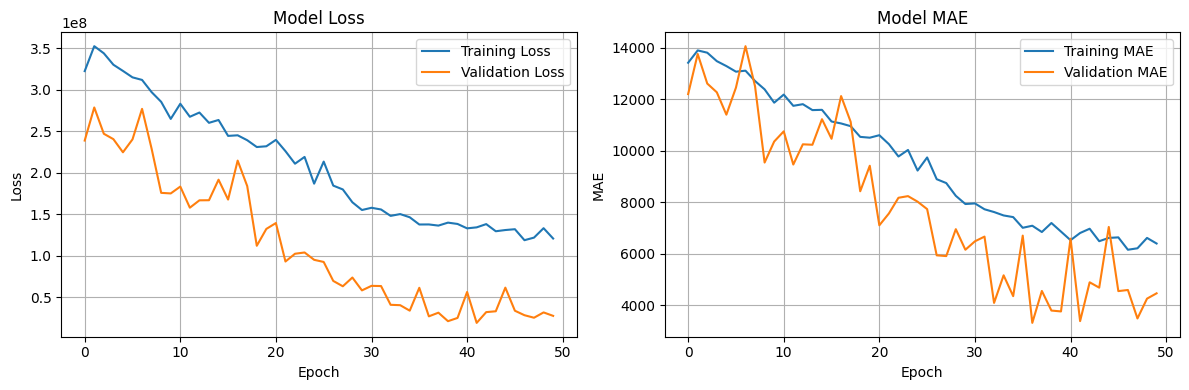

NameError: name 'y_test_orig' is not defined

In [15]:
if 'model' in locals() and 'X_train' in locals() and 'y_train' in locals():
    history, X_test_clean, y_test_clean = train_model(model, X_train, y_train, X_test, y_test, epochs=50)
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate model performance
    results = evaluate_model_performance(model, X_test_clean, y_test_clean, scaler_y, y_test_orig)
    
    # Plot predictions vs actual
    plot_predictions_vs_actual(
        results['predictions'], 
        results['actual'], 
        results['target_columns']
    )
    
    print("Training and evaluation completed!")
else:
    print("Model or training data not available. Please run previous cells first.")


## Prediction Functions

This section provides functions to make predictions on new data using the trained model.


In [ ]:
def predict_next_step(model, new_data_df, scaler_X, scaler_y, timesteps=1):
    """
    Make predictions on new data using the trained LSTM model.
    
    Args:
        model: Trained LSTM model
        new_data_df (pd.DataFrame): DataFrame containing historical data for feature calculation
        scaler_X: Fitted scaler for input features
        scaler_y: Fitted scaler for target variables
        timesteps (int): Number of timesteps the LSTM expects
    
    Returns:
        pd.DataFrame: Predictions for the next time step
    """
    if new_data_df is None or new_data_df.empty:
        print("Error: No new data provided for prediction.")
        return None
    
    # Create features using the same preprocessing as training
    features_df = create_features(new_data_df)
    
    # Remove original features (keep only engineered ones)
    features_df = features_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Hour_sin', 'Hour_cos'])
    
    # Get the last valid row of features
    latest_features = features_df.dropna().iloc[[-1]].copy()
    
    if latest_features.empty:
        print("Error: Not enough valid data to calculate features for prediction.")
        return None
    
    # Scale the features
    latest_features_scaled = scaler_X.transform(latest_features)
    
    # Reshape for LSTM input
    latest_features_lstm = latest_features_scaled.reshape((1, timesteps, latest_features_scaled.shape[1]))
    
    # Make prediction
    predictions_scaled = model.predict(latest_features_lstm)
    
    # Inverse transform predictions
    predictions = scaler_y.inverse_transform(predictions_scaled)
    
    # Convert to DataFrame
    target_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    prediction_df = pd.DataFrame(predictions, columns=target_columns)
    
    return prediction_df


def generate_sample_data(original_data, n_samples=100, noise_factor=0.001):
    """
    Generate sample data for testing predictions.
    
    Args:
        original_data: Original DataFrame to use as template
        n_samples: Number of samples to generate
        noise_factor: Amount of noise to add (as fraction of standard deviation)
    
    Returns:
        pd.DataFrame: Generated sample data
    """
    # Take the last n_samples from original data
    sample_data = original_data.tail(n_samples).copy()
    
    # Add small amount of noise to make it different
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        noise = np.random.randn(len(sample_data)) * sample_data[col].std() * noise_factor
        sample_data[col] = sample_data[col] + noise
    
    return sample_data


def demonstrate_prediction(model, scaler_X, scaler_y, original_data):
    """
    Demonstrate prediction functionality with sample data.
    
    Args:
        model: Trained LSTM model
        scaler_X: Fitted scaler for input features
        scaler_y: Fitted scaler for target variables
        original_data: Original data to use for generating samples
    """
    print("Generating sample data for prediction demonstration...")
    
    # Generate sample data
    sample_data = generate_sample_data(original_data, n_samples=100)
    
    print(f"Sample data shape: {sample_data.shape}")
    print("Last 5 rows of sample data:")
    display(sample_data[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']].tail())
    
    # Make prediction
    print("\nMaking prediction for next time step...")
    prediction = predict_next_step(model, sample_data, scaler_X, scaler_y)
    
    if prediction is not None:
        print("Predicted values for next time step:")
        display(prediction)
        
        # Show the actual next values for comparison (if available)
        if len(original_data) > len(sample_data):
            actual_next = original_data.iloc[len(sample_data):len(sample_data)+1][['Open', 'High', 'Low', 'Close', 'Volume']]
            print("\nActual values for comparison:")
            display(actual_next)
    else:
        print("Failed to generate prediction.")


In [ ]:
# Demonstrate prediction functionality
if 'model' in locals() and 'scaler_X' in locals() and 'scaler_y' in locals() and 'btc_data' in locals():
    demonstrate_prediction(model, scaler_X, scaler_y, btc_data)
else:
    print("Model, scalers, or data not available. Please run training first.")


## Additional Visualization Functions

This section provides additional visualization utilities for analyzing the data and model performance.


In [ ]:
def plot_price_data(df, title="Cryptocurrency Price Data", max_points=2000):
    """
    Plot the original price data.
    
    Args:
        df: DataFrame with OHLCV data
        title: Plot title
        max_points: Maximum number of points to plot
    """
    n_points = min(len(df), max_points)
    data_subset = df.tail(n_points)
    
    plt.figure(figsize=(15, 10))
    
    # Price subplot
    plt.subplot(2, 2, 1)
    plt.plot(data_subset['Open time'], data_subset['Close'], label='Close Price', alpha=0.8)
    plt.title('Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Volume subplot
    plt.subplot(2, 2, 2)
    plt.plot(data_subset['Open time'], data_subset['Volume'], label='Volume', color='orange', alpha=0.8)
    plt.title('Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # OHLC subplot
    plt.subplot(2, 2, 3)
    plt.plot(data_subset['Open time'], data_subset['Open'], label='Open', alpha=0.7)
    plt.plot(data_subset['Open time'], data_subset['High'], label='High', alpha=0.7)
    plt.plot(data_subset['Open time'], data_subset['Low'], label='Low', alpha=0.7)
    plt.plot(data_subset['Open time'], data_subset['Close'], label='Close', alpha=0.7)
    plt.title('OHLC Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Price distribution
    plt.subplot(2, 2, 4)
    plt.hist(data_subset['Close'], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Close Price Distribution')
    plt.xlabel('Price (USDT)')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_prediction_errors(predictions, actual, target_columns):
    """
    Plot prediction errors for each target variable.
    
    Args:
        predictions: Predicted values
        actual: Actual values
        target_columns: List of target column names
    """
    errors = actual - predictions
    
    fig, axes = plt.subplots(len(target_columns), 1, figsize=(15, 3 * len(target_columns)))
    if len(target_columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(target_columns):
        axes[i].plot(errors[:, i], label=f'Error ({col})', alpha=0.7, color='red')
        axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[i].set_title(f'Prediction Error for {col}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Error')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_feature_importance(feature_names, model_weights=None):
    """
    Plot feature importance if available.
    
    Args:
        feature_names: List of feature names
        model_weights: Model weights (if available)
    """
    if model_weights is None:
        print("Feature importance not available for LSTM models.")
        return
    
    # This is a placeholder - LSTM feature importance is complex
    # In practice, you might use permutation importance or SHAP values
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_names)), model_weights)
    plt.title('Feature Importance (Placeholder)')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.tight_layout()
    plt.show()


def create_summary_report(results, model_history=None):
    """
    Create a summary report of model performance.
    
    Args:
        results: Results dictionary from evaluate_model_performance
        model_history: Training history (optional)
    """
    print("=" * 60)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 60)
    
    print("\nMSE Scores:")
    for col, mse in results['mse_scores'].items():
        print(f"  {col}: {mse:.4f}")
    
    # Calculate overall performance
    avg_mse = np.mean(list(results['mse_scores'].values()))
    print(f"\nAverage MSE: {avg_mse:.4f}")
    
    if model_history is not None:
        final_train_loss = model_history.history['loss'][-1]
        final_val_loss = model_history.history['val_loss'][-1]
        print(f"\nFinal Training Loss: {final_train_loss:.4f}")
        print(f"Final Validation Loss: {final_val_loss:.4f}")
    
    print("\nModel Architecture:")
    print("  - Type: LSTM (Long Short-Term Memory)")
    print("  - Input Shape: (timesteps, features)")
    print("  - Output: Multi-output regression")
    print("  - Targets: Open, High, Low, Close, Volume")
    
    print("\nData Information:")
    print(f"  - Training samples: {len(results['actual'])}")
    print(f"  - Features per sample: {results['predictions'].shape[1]}")
    
    print("=" * 60)


In [ ]:
# Additional visualizations and analysis
if 'btc_data' in locals() and btc_data is not None:
    print("Plotting original price data...")
    plot_price_data(btc_data, "Bitcoin Price Data (2021)")
    
if 'results' in locals() and results is not None:
    print("\nPlotting prediction errors...")
    plot_prediction_errors(results['predictions'], results['actual'], results['target_columns'])
    
    print("\nGenerating summary report...")
    if 'history' in locals():
        create_summary_report(results, history)
    else:
        create_summary_report(results)
else:
    print("Data or results not available for additional visualizations.")
